In [2]:
import sys
sys.path.append(r"C:\Users\trund\QRT")

import backtesting # To backtest the strategy
import eda_package

from typing import Optional, List, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import scipy.stats as stats
import yfinance as yf

In [15]:
def generate_jd_dataset(ticker, period, sma_windows) -> pd.DataFrame:

    # 1. Download data (auto_adjust=False ensures we get both Close and Adj Close)
    data = yf.download(ticker, period=period, auto_adjust=False)
    
    # Flatten Multi-Index if necessary
    if isinstance(data.columns, pd.MultiIndex):
        # This keeps all price types (Open, High, Low, Close, Adj Close, Volume)
        df = data.stack(level=1, future_stack=True).loc[(slice(None), ticker), :].reset_index(level=1, drop=True)
    else:
        df = data.copy()

    # Adjust names of columns before proceeding
    df.columns = [column.replace(" ", "_") for column in df.columns]

    # 2. Simple Moving Average (using Adjusted Close for better accuracy)
    df[f"SMA_{sma_windows[0]}"] = df['Adj_Close'].rolling(window=sma_windows[0]).mean()
    df[f"SMA_{sma_windows[1]}"] = df['Adj_Close'].rolling(window=sma_windows[1]).mean()
    df[f"SMA_{sma_windows[2]}"] = df['Adj_Close'].rolling(window=sma_windows[2]).mean()


    # 3. Momentum Signal (RSI)
    delta = df['Adj_Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['Momentum_RSI'] = 100 - (100 / (1 + rs))

    # 4. Log Returns (calculated on Adjusted Close)
    df['Log_Returns'] = np.log(df['Adj_Close'] / df['Adj_Close'].shift(1))

    # 5. Unusual Volume Logic
    vol_avg = df['Volume'].rolling(window=20).mean()
    vol_std = df['Volume'].rolling(window=20).std()
    df['Unusual_Volume'] = np.where(df['Volume'] > (vol_avg + 1.5 * vol_std), 1, 0)

    # Drop NaNs and reorder for clarity - verified that the only missing dates are from SMA
    df.dropna(inplace=True)
    cols = ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', f"SMA_{sma_windows[0]}", f"SMA_{sma_windows[1]}", f"SMA_{sma_windows[2]}", 'Momentum_RSI', 'Log_Returns', 'Unusual_Volume']
    return df[cols]

# Run and inspect
ticker= "NVDA"
sma_windows = [10, 50, 100]
dataset = generate_jd_dataset(ticker=ticker, period="3y", sma_windows=sma_windows)
print(dataset[['Close', 'Adj_Close', 'Log_Returns']].head())
# Run the fixed function

# fig, ax = plt.subplots(1, 1, figsize=(12, 10), sharex=True)
# ax.plot(dataset.index, dataset['Adj_Close'], label='Close Price', color='blue')
# ax.plot(dataset.index, dataset[f"SMA_{sma_windows[0]}"], label=f"SMA_{sma_windows[0]}", color='orange', alpha=0.5)
# ax.plot(dataset.index, dataset[f"SMA_{sma_windows[1]}"], label=f"SMA_{sma_windows[1]}", color='red', alpha=0.5)
# ax.set_title(f'{ticker} Close Price and SMAs') 
# ax.set_xlabel('Date')
# ax.set_ylabel('Price (GBP)')
# ax.legend()

# Overall, the strategy looks decent, should try implementing it. Buy when cross at 30, 50, sell when cross at 30 

def sma_crossover_strategy_base(tradable_assets, history, position_history, short_window=10, long_window=50):
    
    # Immediately create a buy signal with all capital when the windows cross 
    if history.iloc[-1][f"SMA_{short_window}"] >= history.iloc[-1][f"SMA_{long_window}"]:

        labels_and_weights = pd.Series(data=np.ones(shape=len(tradable_assets)), index=tradable_assets)
        cash = 0.0
        
    else:
        labels_and_weights = pd.Series(data=-np.zeros(shape=len(tradable_assets)), index=tradable_assets)
        cash = 0.0


    return cash, labels_and_weights

def sma_crossover_strategy(tradable_assets, history, position_history):
    return sma_crossover_strategy_base(tradable_assets, history, position_history, short_window=10, long_window=50)
        
tradable_assets = ["NVDA"]
nvda_adj = dataset.copy()
nvda_adj.columns = ["NVDA" if column == "Adj_Close" else column for column in nvda_adj.columns]
backtest = backtesting.Backtester(tradable_assets=tradable_assets, 
                       strategy_fn = sma_crossover_strategy, 
                       strategy_name = "sma_crossover_strategy", 
                       allow_short=True,
                       data = nvda_adj, 
                       slippage=0.00, 
                       commission=0.05)



backtest.run(verbose=True)
backtest.trades
#sma_crossover_strategy(tradable_assets, nvda_adj, position_history=0)

[*********************100%***********************]  1 of 1 completed


                Close  Adj_Close  Log_Returns
Date                                         
2023-06-13  41.021999  40.992176     0.038264
2023-06-14  42.997002  42.965744     0.047022
2023-06-15  42.653000  42.621998    -0.008033
2023-06-16  42.692001  42.660961     0.000914
2023-06-20  43.807999  43.776150     0.025805
2023-06-14: executing pending target 
 NVDA    1.0
dtype: float64

Current prices executed at: 
NVDA    42.965744
Name: 2023-06-14 00:00:00, dtype: float64
NVDA    2327.435549
dtype: float64 

2023-06-15: executing pending target 
 NVDA    1.0
dtype: float64

Current prices executed at: 
NVDA    42.621998
Name: 2023-06-15 00:00:00, dtype: float64
NVDA   -117.310315
dtype: float64 

2023-06-16: executing pending target 
 NVDA    1.0
dtype: float64

Current prices executed at: 
NVDA    42.660961
Name: 2023-06-16 00:00:00, dtype: float64
NVDA   -5.860159
dtype: float64 

2023-06-20: executing pending target 
 NVDA    1.0
dtype: float64

Current prices executed at: 
NVDA   

[Trade(date=Timestamp('2023-06-14 00:00:00'), shares={'NVDA': np.float64(2327.435548580636)}, price={'NVDA': np.float64(42.96574401855469)}, commission=5000.0, note=None),
 Trade(date=Timestamp('2023-06-15 00:00:00'), shares={'NVDA': np.float64(-117.3103151936065)}, price={'NVDA': np.float64(42.62199783325195)}, commission=250.0, note=None),
 Trade(date=Timestamp('2023-06-16 00:00:00'), shares={'NVDA': np.float64(-5.860158638114012)}, price={'NVDA': np.float64(42.66096115112305)}, commission=12.5, note=None),
 Trade(date=Timestamp('2023-06-20 00:00:00'), shares={'NVDA': np.float64(-0.2855436138506965)}, price={'NVDA': np.float64(43.77614974975586)}, commission=0.6250000000007275, note=None),
 Trade(date=Timestamp('2023-06-21 00:00:00'), shares={'NVDA': np.float64(-0.014530250928510464)}, price={'NVDA': np.float64(43.013710021972656)}, commission=0.031249999999272405, note=None),
 Trade(date=Timestamp('2023-06-22 00:00:00'), shares={'NVDA': np.float64(-0.0007268503877864555)}, price={'N

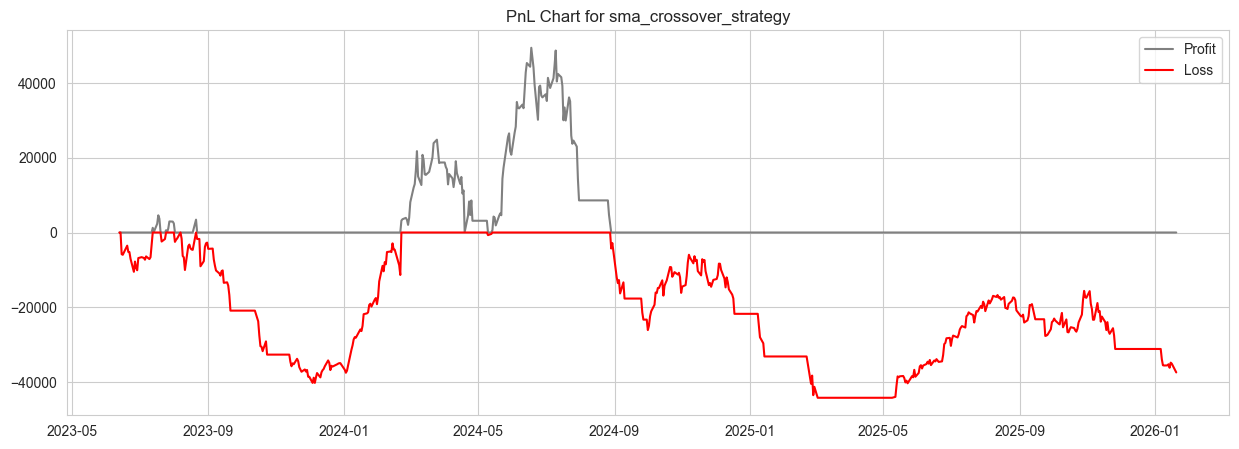

Date
2023-06-13    100000.000000
2023-06-14    100000.000000
2023-06-15     94199.952909
2023-06-16     94036.066721
2023-06-20     96481.738000
                  ...      
2026-01-13     64764.207329
2026-01-14     63833.576485
2026-01-15     65196.410976
2026-01-16     64910.596840
2026-01-20     62585.764257
Length: 653, dtype: float64

In [18]:
backtest.plot_pnl_curve()
backtest.nav_history